# Hands-On Convolutional Neural Network

Coral reefs are among the most diverse and valuable ecosystems on Earth, providing habitat for 25% of all marine species and supporting the livelihoods of over half a billion people worldwide. However, these ecosystems face unprecedented threats from climate change, ocean acidification, and other human activities, with many species now endangered.

We are given a dataset containing images of three different coral species:
 - *Acropora cervicornis* (Staghorn Coral)
 - *Colpophyllia natans* (Boulder Brain Coral)
 - *Montastraea cavernosa* (Greater Star Coral)

Our task is to build a Convolutional Neural Network (CNN) that can classify the coral images into the correct species. This technology can help automate coral reef monitoring efforts and support conservation initiatives by enabling rapid, large-scale species identification.


## Part 1: Building a CNN Model from Scratch
### Step 0. Check GPU Availability and TensorFlow Version

Before training deep learning models, it's important to check whether TensorFlow can access the GPU on your machine. Training on a GPU is significantly faster than on a CPU, especially for large image image datasets.

If you've followed the setup instructions in the [GitHub README](https://github.com/kbeavers/coral-species-CNN-tutorial/blob/main/README.md), and you've run the `install_kernel.sh` script on **Frontera**, you should now be running this notebook inside a containerized Jupyter kernel that includes:
- TensorFlow with GPU support
- CUDA libraries compatible with the system
- All required Python packages pre-installed

This cell will confirm that your environment is correctly configured (TIP: Make sure you change your kernel to `tf-213`.) 

In [7]:
import tensorflow as tf

# Check if TensorFlow can detect a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Print TensorFlow version (should be ____)
print(tf.__version__)

Num GPUs Available:  4
2.13.0


### Step 1. Data Loading and Organization
In this step, we load all coral images from the dataset directory and organize them into a DataFrame. Each image is assigned a label based on the name of the directory it's stored in (i.e., 'ACER' - *Acropora cervicornis*, 'CNAT' - *Colpophyllia natans*, 'MCAV' - *Montastraea cavernosa*).

This DataFrame will serve as the foundation for splitting our data into training, validation, and test sets later in the tutorial.

#### 1.1. List Dataset Directory Contents
Before loading the images, we first want to inspect the directory structure to make sure everything is in the right place. The code below lists the contents of the `coral-species` data directory to verity that the subdirectories for each coral species are present and correctly named:

In [8]:
from pathlib import Path

# Define the path to the dataset directory
# NOTE: Replace the path below with the full path to your scratch directory containing the training materials
dataset_dir = Path('/scratch1/09794/kbeavers/tacc-deep-learning-tutorials/data/coral-species')

# List the contents of the data directory
print(list(dataset_dir.iterdir()))

[PosixPath('/scratch1/09794/kbeavers/tacc-deep-learning-tutorials/data/coral-species/CNAT'), PosixPath('/scratch1/09794/kbeavers/tacc-deep-learning-tutorials/data/coral-species/MCAV'), PosixPath('/scratch1/09794/kbeavers/tacc-deep-learning-tutorials/data/coral-species/ACER')]


#### 1.2. Check File Extensions
Next, we scan the dataset directory and all its subdirectories to find out what types of image files are present. This helps us catch unexpected or unsupported file types (e.g., GIFs, txt files, etc.), which could cause problems later when loading images.

This also allows us to see if the images are all in the same format or not.

In [9]:
# Recursively list all files under the dataset directory
image_files = list(dataset_dir.rglob("*"))

# Extract and print the unique file extensions
# This helps us confirm that only valid image files are present
extensions = set(p.suffix.lower() for p in image_files if p.is_file())
print("File extensions found:", extensions)

File extensions found: {'.jpg'}


#### 1.3. Explore Image Dimensions and Color Modes
Before feeding images into a CNN, it's important to understand the basic properties of the dataset. In this step, we examine the **dimensions** (width x height) as well as the **color mode** (e.g., RGB, RGBA, grayscale) of each image. This helps us decide if we need to resize or convert images before we begin training our CNN.

The script below prints a summary and gives recommendations if inconsistencies are found.

In [10]:
from PIL import Image
from pathlib import Path
from collections import Counter

def explore_image_dataset(dataset_dir):
    """
    Explore basic properties of images: size and color mode.
    """
    print("Starting image dataset exploration...\n")

    # Gather all .jpg files in the dataset
    image_files = list(Path(dataset_dir).rglob('*.jpg'))
    print(f"Found {len(image_files)} image files\n")

    # Track sizes and color modes
    image_sizes = []
    color_modes = []

    print("Checking image dimensions and color modes...\n")
    for img_path in image_files:
        with Image.open(img_path) as img:
            image_sizes.append(img.size)
            color_modes.append(img.mode)

    # Summarize image sizes
    size_counts = Counter(image_sizes)
    print("=== Image Sizes ===")
    print(f"Found {len(size_counts)} unique image sizes:")
    for size, count in size_counts.most_common():
        print(f"- {size}: {count} images")

    # Summarize color modes
    mode_counts = Counter(color_modes)
    print("\n=== Color Modes ===")
    print(f"Found {len(mode_counts)} unique color modes:")
    for mode, count in mode_counts.most_common():
        print(f"- {mode}: {count} images")

    # Simple recommendations
    print("\n=== Recommendations ===")
    if len(size_counts) > 1:
        print(f"Images have different sizes. Consider resizing.")
    else:
        print("All images are the same size.")

    if len(mode_counts) > 1:
        print("Images have different color modes. Consider converting to RGB.")
    else:
        print("All images share the same color mode.")

# Run the function
explore_image_dataset(dataset_dir)

Starting image dataset exploration...

Found 417 image files

Checking image dimensions and color modes...

=== Image Sizes ===
Found 63 unique image sizes:
- (800, 600): 231 images
- (800, 533): 36 images
- (600, 800): 29 images
- (800, 534): 13 images
- (533, 800): 10 images
- (800, 450): 8 images
- (800, 602): 8 images
- (800, 700): 7 images
- (534, 800): 7 images
- (800, 449): 4 images
- (800, 601): 4 images
- (800, 640): 3 images
- (800, 800): 3 images
- (800, 545): 2 images
- (800, 634): 2 images
- (700, 800): 2 images
- (800, 599): 2 images
- (800, 370): 1 images
- (800, 451): 1 images
- (800, 378): 1 images
- (800, 669): 1 images
- (800, 535): 1 images
- (800, 711): 1 images
- (800, 619): 1 images
- (800, 629): 1 images
- (800, 491): 1 images
- (691, 800): 1 images
- (692, 800): 1 images
- (800, 530): 1 images
- (694, 800): 1 images
- (730, 800): 1 images
- (800, 667): 1 images
- (800, 665): 1 images
- (800, 731): 1 images
- (800, 744): 1 images
- (607, 800): 1 images
- (800, 5

Our dataset analysis reveals some important characteristics that we'll need to keep in mind as we proceed with the tutorial:
 1. **Image Size Variation**: We have 417 total images in our dataset, with 63 different image sizes (dimensions). Also notice that some images are in portrait orientation (height > width) while others are landscape (width > height). CNNs expect all images to have the same dimensions, so we'll need to resize them to a standard size before training our model. 
 2. **Color Mode**: All images share the same color mode. Great!

We will address this again in Step 4 when we prepare our data for input into the CNN. 

#### 1.4 Check for Corrupted Images

Before continuing, we want to make sure that all image files are readable. Corrupted files can break your model training or cause unexpected errors during preprocessing.

In this step, we:
1. Attempt to open each '.jpg' file using PIL
2. Discard any files that fail to load

This ensures we only keep clean, valid images for training.

In [11]:
from tqdm import tqdm

# Find all .jpg files in the dataset
image_paths = list(dataset_dir.rglob('*.jpg'))

# Create lists to store valid and corrupted files
valid_images = []
bad_images = []

print("Checking for corrupted images...\n")

# tqdm adds a progress bar to show how long the process will take
for path in tqdm(image_paths):
    try:
        # Try to open and verify the image
        with Image.open(path) as img:
            img.verify()
        # If the image is valid, add it to valid_images
        valid_images.append(path)

    except Exception:
        # If any error occurs while opening/verifying the image, add it to bad_images
        bad_images.append(path)

print(f"Valid images: {len(valid_images)}")
print(f"Corrupted images removed: {len(bad_images)}")

Checking for corrupted images...



100%|██████████| 417/417 [00:03<00:00, 109.31it/s]

Valid images: 417
Corrupted images removed: 0


If there are any corrupted images in your dataset, this code will automatically remove them.

#### 1.5. Create a DataFrame of Image Paths and Labels
Now that we have taken a peak at the format of our data and have removed any corrupted images, we can start setting up our data for training. In this step, we build a `pandas.DataFrame` that organizes all the image data into two columns:
 1. **filepath**: The full path to each image file
 2. **label**: The class label for each image, taken from the directory name

This structured DataFrame is essential for training with Keras' `flow_from_dataframe` method that we'll use later in this tutorial.

In [13]:
import pandas as pd

# Set pandas to display full column content (no truncation)
pd.set_option('display.max_colwidth', None)

# Build (filepath, label) pairs from valid image paths
data = []
for path in valid_images:
    label = path.parent.name # Extract label from directory name
    data.append((str(path), label))

# Create a DataFrame with columns for filepath and label
df = pd.DataFrame(data, columns=["filepath", "label"])

# (Optional) Shuffle the DataFrame to randomize order of images
df = df.sample(frac=1, random_state=123).reset_index(drop=True)

# Show a preview of the DataFrame
df.head()

,filepath,label
0,/scratch1/09794/kbeavers/tacc-deep-learning-tutorials/data/coral-species/ACER/acropora_059.jpg,ACER
1,/scratch1/09794/kbeavers/tacc-deep-learning-tutorials/data/coral-species/CNAT/colpophyllia_051.jpg,CNAT
2,/scratch1/09794/kbeavers/tacc-deep-learning-tutorials/data/coral-species/ACER/acropora_134.jpg,ACER
3,/scratch1/09794/kbeavers/tacc-deep-learning-tutorials/data/coral-species/MCAV/montastraea_110.jpg,MCAV
4,/scratch1/09794/kbeavers/tacc-deep-learning-tutorials/data/coral-species/ACER/acropora_091.jpg,ACER


### Step 2. Visualize the Data
### 2.1 Visualize the Class Distribution
Before we start training, it's important to understand how many images we have for each class (in this case, coral species).

In this step we:
 1. Count how many images belong to each class
 2. Plot the class distribution as a pie chart and bar graph

If the dataset is imbalanced (i.e., some classes have far more images than others), we may need to account for this later using **class weights**.

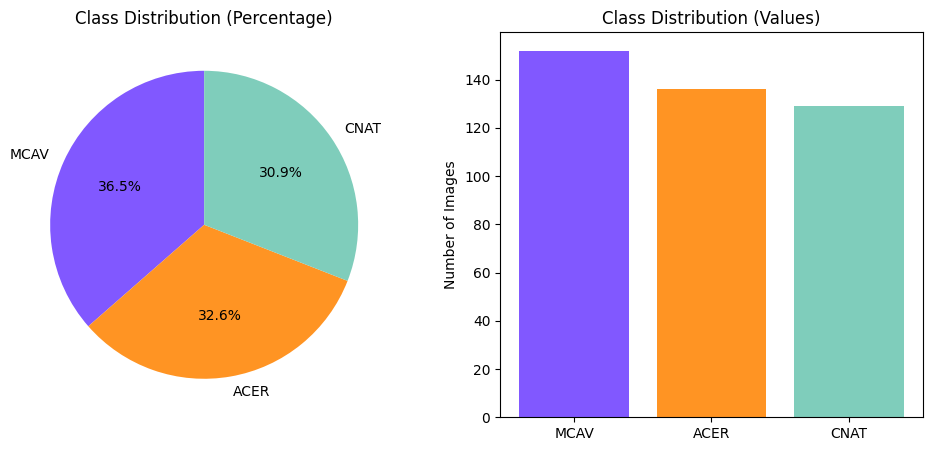

MCAV: 152 images (36.45%)
ACER: 136 images (32.61%)
CNAT: 129 images (30.94%)


In [20]:
import matplotlib.pyplot as plt

# Count class distribution (counts how many times each unique value appears in the 'label' column of your DataFrame)
counts = df['label'].value_counts()

# Create a figure with two plots side-by-side (1-row, 2-columns; 12 inches wide, 5 inches tall)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define a color palette
colors = ['#8158ff', '#ff9423', '#7fcdbb']

# Create a Pie chart in the first plot position (axes[0])
## counts.values: The number of images for each class
## counts.index: The class labels (e.g., 'ACER', 'CNAT', 'MCAV')
## autopct='%1.1f%%': Display the percentage of images for each class
## colors: The colors to use for each class (defined earlier)
axes[0].pie(counts.values, labels=counts.index, autopct='%1.1f%%', colors=colors)
axes[0].set_title('Class Distribution (Percentage)')

# Creates a Bar chart in the second plot position (axes[1])
axes[1].bar(counts.index, counts.values, color=colors)
axes[1].set_title('Class Distribution (Values)')
axes[1].set_ylabel('Number of Images')

# Display the figure with both charts
plt.show()

# Print label counts and percentages
for label, count in counts.items():
    print(f"{label}: {count} images ({count/len(df)*100:1.2f}%)")

**Thought Challenge**: Describe the class distribution in your own words. How much of the dataset is made up by the largest class? The smallest class? Is there anything that we need to address before continuing?

#### 2.2 Visualize Images from the Dataset
It's helpful to look at a few images from each class to get a better understanding of the dataset. This will give us a better sense of:
 - What each coral species looks like
 - How much visual variation exists within each class (e.g., different angles, lighting, etc.)
 - Whether the dataset includes noise, blur, or other artifacts

We'll display a grid of randomly selected images, grouped by class.

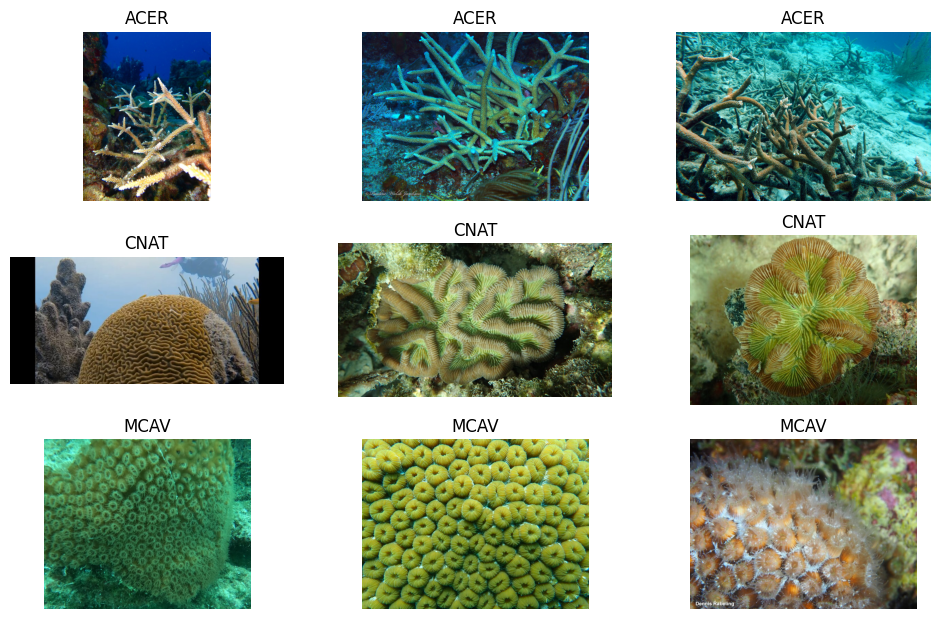

In [17]:
from tensorflow.keras.preprocessing.image import load_img

# Set the number of images to display per class
samples_per_class = 3

# Get list of unique coral species names (classes)
classes = df['label'].unique()

# Create a figure with appropriate size
# The height (2.5 * len(classes)) ensures enough space for all images
plt.figure(figsize=(12, len(classes) * 2.5))

# Loop through each class to create a grid of images
for i, label in enumerate(sorted(classes)):
    # Filter DataFrame to get only images from the current class
    class_df = df[df['label'] == label]

    # Randomly select 3 images from the current class
    sample_paths = random.sample(list(class_df['filepath']), samples_per_class)

    # Create subplot for each image
    for j, img_path in enumerate(sample_paths):

        # Calculate position in grid: (row * width) + column + 1
        plt.subplot(len(classes), samples_per_class, i * samples_per_class + j + 1)

        # Load and display the image
        img = load_img(img_path)        # Load the image
        plt.imshow(img)                 # Display the image
        plt.title(label)                # Add species name as title
        plt.axis('off')

plt.show()

*Remember: the quality of a machine learning model is decided largely by the quality of the dataset it was trained on!*

### Step 3: Split the Dataset and Handle Class Imbalance

#### 3.1. Split the Dataset into Training, Validation and Test Sets
We are now ready to split our labelled image dataset into three parts:

 - **Training Set**: Used to train the model
 - **Validation Set**: Used to tune hyperparameters and monitor training
 - **Test Set**: Used to evaluate the final model's performance after training is complete

We use `train_test_split()` from scikit-learn in two stages:

 1. First, we split the original dataset into **training + test** sets
 2. Then, we split the training set again into **training + validation**.

This ensures that our CNN *never sees the test set* during training, which is important for obtaining an unbiased estimate of the model's performance. 

To preserve the class distribution across all splits, we use `stratify=df["label"]` to ensure each subset reflects the original proportions of each class. This is called **stratified sampling**.

In [1]:
from sklearn.model_selection import train_test_split

# First, split the original dataset into training + test sets
train_df, test_df = train_test_split(
    df,                             # This is our DataFrame from step 1.5
    test_size=0.2,                  # How much of the data should be in the test set?
    stratify=df["label"]            # Ensure each split maintains original class distribution
)

# Then, split the training set into training + validation sets
train_df, val_df = train_test_split(
    train_df,                       # What goes here?
    test_size=0.2,                  # How much of the data should be in the validation set?
    stratify=train_df["label"]     # Ensure each split maintains original class distribution
)

# Print split sizes
total = len(df)
print(f"\nDataset splits:")
print(f"Train: {len(train_df)} images ({len(train_df)/total:.2%})")
print(f"Validation: {len(val_df)} images ({len(val_df)/total:.2%})")
print(f"Test: {len(test_df)} images ({len(test_df)/total:.2%})")

NameError: name 'df' is not defined

#### Step 3.2: Compute Class Weights

If our dataset is imbalanced (i.e., some classes have many more images than others), the model may learn to favor those majority classes. To address this, we can compute **class weights** based on the training data using the `compute_class_weight` function from scikit-learn.

These weights:
 - Assign higher important to underrepresented classes
 - Are passed into `model.fit()` using the `class_weight` argument
 - Adjust how the loss is calculated during training

This technique helps the model give balanced attention to all classes during training.

While our dataset is quite balanced, we provide the code for computing class weights below:

In [19]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get unique class labels
class_labels = np.unique(train_df['label'])

# Compute class weights based on training labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=train_df['label']
)

# Convert to a dictionary: {index: weight}
class_weight_dict = dict(zip(range(len(class_labels)), class_weights))

# Preview the result
print("Computed class weights:")
for index, weight in class_weight_dict.items():
    print(f"{index}: {weight:.2f}")

Computed class weights:
0: 1.02
1: 1.08
2: 0.91


In the above output, `0` corresponds to ACER, `1` corresponds to CNAT, and `2` corresponds to MCAV. The class weights are inversely proportional to the number of samples in each class: classes with fewer samples get higher weights to compensate for their underrepresentation. 

We need to convert the string labels (like 'ACER', 'CNAT', 'MCAV') to integers (0, 1, 2) because the model expects numeric class indices. The class_weight_dict maps these numeric indices to their corresponding weights. For example, if MCAV has weight 0.91, it means it's slightly overrepresented in the training set, while a weight > 1 would indicate underrepresentation. This helps balance the training by giving more importance to underrepresented classes and less importance to overrepresented ones.

These weights will be used during training to adjust the loss calculation - the model will pay more attention to mistakes made on underrepresented classes by scaling their loss values higher.

### Step 4: Image Preprocessing and Data Generators
As we discovered in Step 1.3, we need to prepare our images before feeding them into the CNN. This step involves two key concepts:

**a. Data Generators**

Data generators are special tools that help us efficiently load and preprocess image data in small batches (instead of all at once). Keras provides a built-in data generator called `ImageDataGenerator` that can:
 - Resize all images to a consistent size
 - Normalize pixel values (e.g., from [0-255] to [0-1])
 - Augment the training data with random transformations to improve generalization

Data generators can be used with Keras model methods like `fit()`, `evaluate()`, and `predict()`, which is particularly useful when dealing with large datasets that don't all fit into memory at once. 

**b. Data Augmentation**

Data augmentation is a powerful technique that helps our model learn more robust features by creating variations of our training images. Augmentation techniques not only expand the size of our training set, but also help prevent overfitting by exposing our model to different variations of our images. 

Conveniently, `ImageDataGenerator` also provides a number of built-in augmentation techniques that we can use to augment our training data, such as:
 - Random rotations
 - Zooming in or out
 - Shifting the image left or right
 - Flipping the image horizontally

Each of these modifications creates a new, slightly different version of our training images, helping our model learn to recognize the same features in different orientations.

#### 4.1 Define Image Preprocessing and Augmentation
We will define three separate `ImageDataGenerator` objects, one for each dataset split (train, val, test):
 - `train_datagen` will apply both normalization and augmentation to the training data
 - `val_datagen` and `test_datagen` will only apply normalization (no augmentation)

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    rotation_range=30,          # Augment: Random rotation
    width_shift_range=0.2,      # Augment: Random horizontal shift
    height_shift_range=0.2,     # Augment: Random vertical shift
    zoom_range=0.2,             # Augment: Random zoom
    horizontal_flip=True,       # Augment: Random horizontal flip
    fill_mode='nearest'         # Augment: After random transformations, fill in missing pixels with nearest neighbor
)

# Validation and test data generators only need normalization – do not augment
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#### Step 4.2 Load Images Using `flow_from_dataframe()`
Now that our preprocessing methods are defined, we can use `flow_from_dataframe()` to load images in batches directly from our labeled DataFrames (`train_df`, `val_df`, and `test_df`).

All generators return batches of preprocessed image tensors and their corresponding labels.

In [22]:
# Set image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,         
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  
    color_mode='rgb',
    shuffle=True
)

# Validation generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 266 validated image filenames belonging to 3 classes.
Found 67 validated image filenames belonging to 3 classes.
Found 84 validated image filenames belonging to 3 classes.


#### Sanity Check: Inspect a Batch from the Training Generator

Let's inspect the output of the `train_generator` to make sure it's working as expected.

In the code below, we:
 - Retrieve one batch of images and labels from the training generator
 - Check the shape of the batch
 - Display a few image-label pairs to confirm the generator is working

In [23]:
# Get one batch from the training generator
images, labels = next(train_generator)

# Check the shape of the batch
print("Image batch shape:", images.shape)    # Should be (BATCH_SIZE, height, width, channels)
print("Label batch shape:", labels.shape)    # Should be (BATCH_SIZE, num_classes)

# Preview the first 5 label vectors
print("\nFirst 5 labels (one-hot encoded):")
print(labels[:5])

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 3)

First 5 labels (one-hot encoded):
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


#### Visualize a Few Images from the Training Generator

Let's display a few images from the training generator along with their decoded class labels.

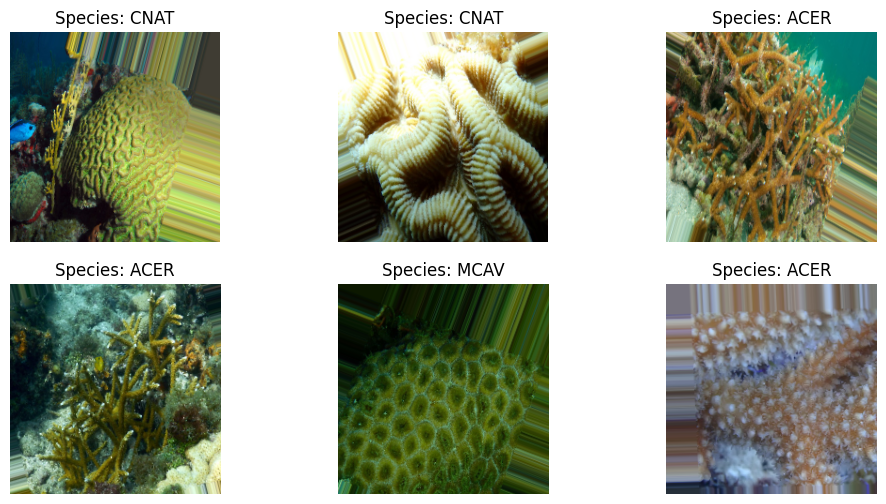

In [29]:
# Get a fresh batch of images
images, labels = next(train_generator)

# Display 6 images in a grid
plt.figure(figsize=(12, 6))

# Show each image
for i in range(6):
    plt.subplot(2, 3, i + 1)

    # Get the species name
    species_names = list(train_generator.class_indices.keys())
    species = species_names[np.argmax(labels[i])]

    # Show the image
    plt.imshow(images[i])
    plt.title(f"Species: {species}")
    plt.axis("off")

plt.savefig('coral_species_augmented.png', dpi=300)
plt.show()

**Thought Challenge**: Look carefully at the images displayed above. Try running the code cell multiple times and changing the code to display images from the validation and test generators. What do you notice about the images that you didn't see before (in Step 3)? Do you notice any differences in the images each time you run the cell? Think about why this might be happening.

### Step 5. Define Your CNN Architecture

Congratulations! Our data is now ready to be used to train a Convolutional Neural Network (CNN) to classify our coral images. 

In this step, we will define the architecture of our CNN model. Below, we define a model that consists of three main parts:

1. **Convolutional Blocks** (Feature Extraction):
   - Block 1: 32 filters (3×3), followed by AveragePooling
   - Block 2: 64 filters (3×3), followed by AveragePooling
   - Block 3: 128 filters (3×3), followed by AveragePooling

   Each block increases the number of filters, allowing the network to detect more complex patterns.

2. **Flatten Layer**:
   - Converts the 3D feature maps to a 1D vector for the dense layers

3. **Dense Layers** (Classification):
   - First dense layer: 128 perceptrons
   - Second dense layer: 64 perceptrons
   - Output layer: 3 perceptrons (one for each coral species)

In [30]:
from tensorflow.keras import models, layers

# Build a custom CNN architecture
cnn_model = models.Sequential([
    # Input layer: matches image shape
    layers.Input(shape=(224, 224, 3)),

    # Convolution Block 1
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.AveragePooling2D((2, 2), padding='same'),

    # Convolution Block 2
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.AveragePooling2D((2, 2), padding='same'),

    # Convolution Block 3
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.AveragePooling2D((2, 2), padding='same'),

    # Flatten to convert 2D feature maps into a 1D vector
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),

    # Output layer: 3 units for 3 classes + softmax for probabilities
    layers.Dense(3, activation='softmax')
])

2025-04-29 11:14:43.194965: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14948 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:02:00.0, compute capability: 7.5
2025-04-29 11:14:43.195605: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14948 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:03:00.0, compute capability: 7.5
2025-04-29 11:14:43.196114: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14948 MB memory:  -> device: 2, name: Quadro RTX 5000, pci bus id: 0000:82:00.0, compute capability: 7.5
2025-04-29 11:14:43.196608: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 14948 MB memory:  -> device: 3, name: Quadro RTX 5000, pci bus id: 0000:83:00.0, comp

Once you have filled in the blanks and defined your model, let's compile it:

In [31]:
from tensorflow.keras.optimizers import RMSprop

cnn_model.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In the code above, we use the `RMSprop` optimizer, which adapts the learning rate based on recent gradients, and is a popular chocie for image classification tasks. We also set the learning rate to `1e-4`, which sets the inital learning rate for the optimizer. 

*Note: while these are good starting choices, you may want to experiment with different optimizers or learning rates based on your model's performance*

Finally, let's display our model architecture and parameter count:

In [32]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 average_pooling2d (Average  (None, 112, 112, 32)      0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 average_pooling2d_1 (Avera  (None, 56, 56, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 average_pooling2d_2 (Avera  (None, 28, 28, 128)       0

## Step 6: Train the CNN Model

Now that our CNN architecture is defined, we can train it using the `fit()` method.

During training, the model will learn patterns in the training data and adjust is parameters to minimize the loss function. After each epoch, the model's performance is evaluated on the validation set.

Here, we also pass in `class_weight` to demonstrate how to handle imbalanced data. 

We also track the training history, which we’ll use later to visualize performance over time.

In [35]:
cnn_history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weight_dict # Computed in Step 3.2
)

Epoch 1/15
9/9 [==============================] - 14s 2s/step - loss: 1.0338 - accuracy: 0.4737 - val_loss: 1.0179 - val_accuracy: 0.5075
Epoch 2/15
9/9 [==============================] - 9s 1s/step - loss: 1.0466 - accuracy: 0.4436 - val_loss: 1.0264 - val_accuracy: 0.4627
Epoch 3/15
9/9 [==============================] - 8s 905ms/step - loss: 1.0224 - accuracy: 0.4624 - val_loss: 0.9770 - val_accuracy: 0.5373
Epoch 4/15
9/9 [==============================] - 11s 1s/step - loss: 1.0178 - accuracy: 0.4624 - val_loss: 1.0147 - val_accuracy: 0.4776
Epoch 5/15
9/9 [==============================] - 9s 899ms/step - loss: 1.0065 - accuracy: 0.4699 - val_loss: 0.9736 - val_accuracy: 0.5075
Epoch 6/15
9/9 [==============================] - 12s 1s/step - loss: 1.0118 - accuracy: 0.5038 - val_loss: 1.0182 - val_accuracy: 0.5373
Epoch 7/15
9/9 [==============================] - 11s 1s/step - loss: 1.0120 - accuracy: 0.4662 - val_loss: 0.9707 - val_accuracy: 0.5373
Epoch 8/15
9/9 [===============

#### Visualize Training History

After training the model, we can visualize the accuracy and loss over time to better understand how the model is learning. These plots can help us identify overfitting, underfitting, or confirm that the model is learning as expected.

We can use the `cnn_history` object returned by the `fit()` method to plot the training and validation accuracy and loss:

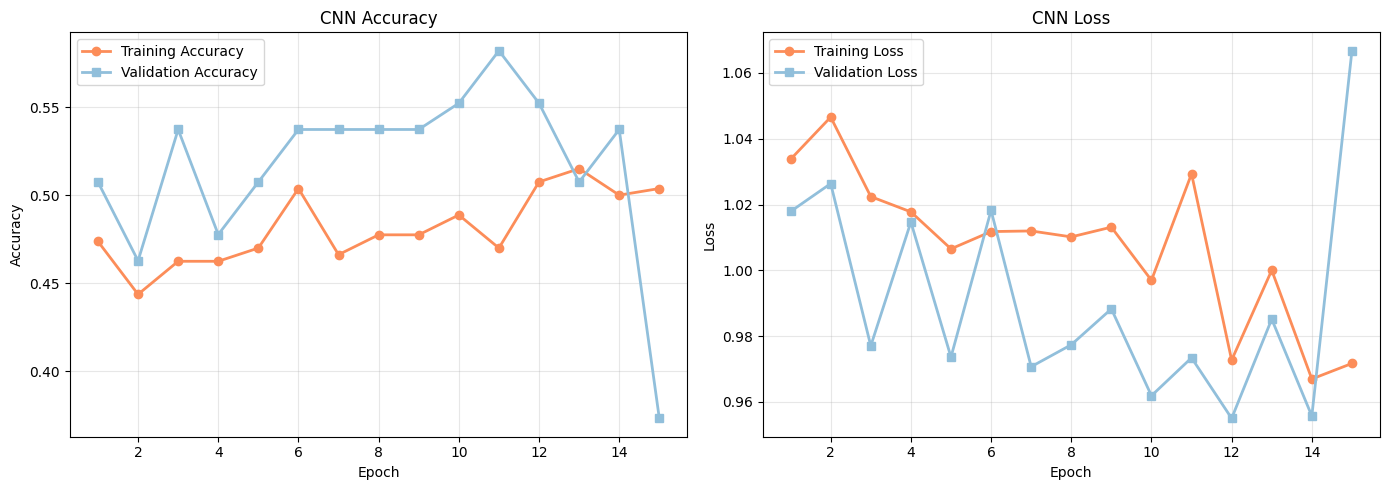

In [37]:
def plot_training_history(history, title_prefix="CNN"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Set color palette
    training_color = '#fc8d59'
    validation_color = '#91bfdb'

    # Plot accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, color=training_color, linestyle='-', marker='o',
            label='Training Accuracy', linewidth=2)
    plt.plot(epochs, val_acc, color=validation_color, linestyle='-', marker='s',
            label='Validation Accuracy', linewidth=2)
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, color=training_color, linestyle='-', marker='o',
            label='Training Loss', linewidth=2)
    plt.plot(epochs, val_loss, color=validation_color, linestyle='-', marker='s',
            label='Validation Loss', linewidth=2)
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history(cnn_history)

The plots above show the training and validation accuracy/loss over 15 epochs. 

**Thought Challenge**: What do you notice about the training and validation accuracy and loss? What does this tell you about the model's learning performance (i.e. overfitting, underfitting, or healthy learning)? 

### Step 7: Evaluate the Model on Test Set

Now that we've trained our model, it's time to evaluate its performance on the test set. This step is crucial because it helps us understand how well the model generalizes to new, unseen data, which is a good indicator of its real-world performance.

#### Evaluate Test Accuracy and Loss

We use `model.evaluate()` to calculate the test accuracy and loss. These metrics give us a quick overview of the model's performance.

In [38]:
# Evaluate test accuracy and loss
test_loss, test_acc = cnn_model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_acc:.2%}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 34.52%
Test Loss: 1.1921


Our model correctly classifies the test images about 35% of the time, and our loss is still quite high. While these numbers provide a snapshot of performance, they don't tell the whole story. Let's dig deeper with a confusion matrix.

#### Visualize Predictions with a Confusion Matrix

A confusion matrix provides a detailed breakdown of the model's predictions compared to the true labels. It helps identifyh which classes are being confused with each other.

3/3 [==============================] - 1s 346ms/step


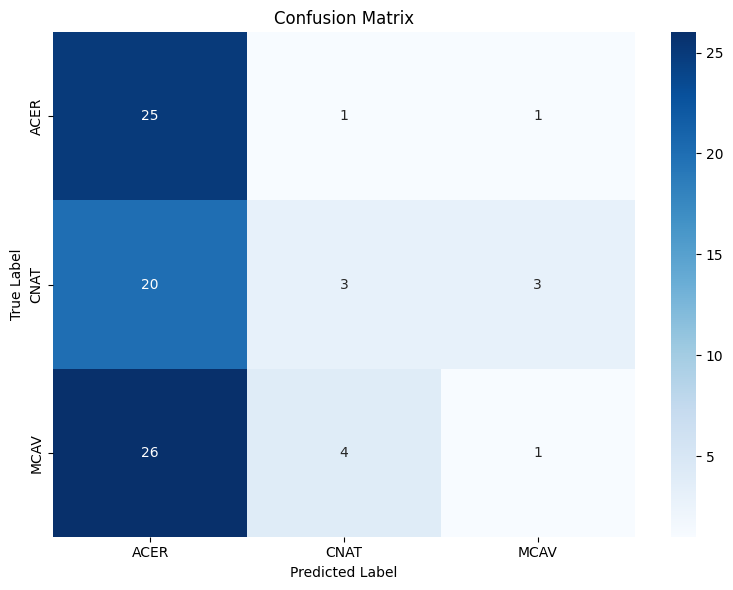

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predicted probabilities for each class
pred_probs = cnn_model.predict(test_generator)

# Convert to predicted class labels
y_pred = np.argmax(pred_probs, axis=1)

# Get true labels
y_true = test_generator.classes

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Map class indices back to names
class_names = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

#### Detailed Performance with a Classification Report

The classification report provides precision, recall, and F1-scores for each class, offering a more nuanced view of model performance.

### Classification Report

In [41]:
from sklearn.metrics import classification_report

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

        ACER       0.35      0.93      0.51        27
        CNAT       0.38      0.12      0.18        26
        MCAV       0.20      0.03      0.06        31

    accuracy                           0.35        84
   macro avg       0.31      0.36      0.25        84
weighted avg       0.30      0.35      0.24        84



**Thought Challenge**: Critically assess the performance of our model based on the accuracy/loss values, confusion matrix, and classification report. Are there any classes that the model is particularly good or bad at predicting? Think about the data and why the model might be performing better or worse for certain classes.

## Part 2: Transfer Learning with VGG19

In this section, we apply a technique called **transfer learning** to improve model performance on our coral classification task.

**Transfer learning** is a deep learning technique where we *reuse a model that has already been trained on a large dataset for a different but related task*. Instead of starting from scratch, we "transfer" the knowledge learned by the pre-trained model to our new task.

This is especially useful when you have a limited dataset, you want to train a model faster, or you want to achieve better accuracy with less computational effort.

We use the **VGG19 model**, a classic convolutional neural network developed by researchers at Oxford University. It was trained on **ImageNet** dataset, which contains over 14 million images across 1000 classes.

### Step 1: Prepare Data for VGG19

#### 1.1 Define Image Preprocessing and Augmentation
VGG19 expects input images to be preprocessed in a very specific way because of the way it was trained. We use the `preprocess_input()` function from `tensorflow.keras.applications.vgg19` to preprocess our images. Specifically, this function converts RGB pixel values to the format VGG19 was originally trained on (i.e., channels in BGR order, zero-centered with respect to ImageNet).

Let's create new data generators for VGG19 using `ImageDataGenerator` with:
 - `preprocess_input` for normalization
 - Augmentation on the training set
 - No augmentation on the validation and test sets

In [42]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Contraints
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Define new ImageDataGenerators for VGG19
vgg19_train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

vgg19_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
vgg19_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

### Step 2: Load Images Using `flow_from_dataframe()'

Just like we did for our CNN model, we can use `flow_from_dataframe()` to load images in batches directly from our labeled DataFrames (`train_df`, `val_df`, and `test_df`).

In [43]:
# Assuming you have train_df, val_df, test_df already split
train_generator_vgg19 = vgg19_train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=123
)

val_generator_vgg19 = vgg19_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator_vgg19 = vgg19_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 266 validated image filenames belonging to 3 classes.
Found 67 validated image filenames belonging to 3 classes.
Found 84 validated image filenames belonging to 3 classes.


### Step 2: Define and Train the VGG19 Model
#### 2.1 Load VGG19 Base Model and Stack a Custom Classifier

We now load the **VGG19 base model**, which has been pre-trained on ImageNet. We exclude the original classification head (`include_top=False`) and freeze all convolutional layers for now.

Next, we stack a **custom classifier** on top using Keras’ `Sequential` API:
- Flatten the output of VGG19’s last convolutional layer
- Add the same fully connected (dense) layers that we had in our original CNN built from scratch

In [44]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load VGG19 base (without top classifier)
vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_base.trainable = False  # Freeze all pretrained layers

# Build the full model
VGG19_model = models.Sequential([
    vgg_base,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # Output layer for 3-class classification
])

Now, let's compile the model with the same optimizer and loss function as our previous model.

In [45]:
# Compile with a low learning rate optimizer
VGG19_model.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#### 2.2 Define Training Callbacks
Next, let's define some **training callbacks**. Callbacks are functions executed during training that allow the training process to change its behavior dynamically.

Some common callbacks include:
- **EarlyStopping**: This callback stops training when a monitored metric (e.g., validation accuracy) stops improving. It helps prevent overfitting by halting training once the model's performance plateaus.
- **ReduceLROnPlateau**: This callback reduces the learning rate when a monitored metric (e.g., validation loss) stops improving. By lowering the learning rate, the model can converge to a better local minimum (preventing it from getting stuck in a suboptimal solution).

In [46]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',      # Monitor validation accuracy
        patience=5,                  # Number of epochs to wait before stopping
        restore_best_weights=True    # Restore the best weights from the epoch with the highest validation accuracy
    ),
    ReduceLROnPlateau(
        monitor='val_loss',          # Monitor validation loss
        factor=0.5,                  # Reduce learning rate by 50%
        patience=3,                  # Number of epochs to wait before reducing learning rate
        min_lr=1e-6                  # Minimum learning rate
    )
]

# Train the model with callbacks
VGG19_history = VGG19_model.fit(
    train_generator_vgg19,
    validation_data=val_generator_vgg19,
    epochs=15,
    class_weight=class_weight_dict,
    callbacks=callbacks             # Pass the callbacks to the fit method
)

Epoch 1/15
9/9 [==============================] - 14s 1s/step - loss: 4.4430 - accuracy: 0.5188 - val_loss: 0.2631 - val_accuracy: 0.9104 - lr: 1.0000e-04
Epoch 2/15
9/9 [==============================] - 7s 855ms/step - loss: 0.6687 - accuracy: 0.8271 - val_loss: 0.4558 - val_accuracy: 0.8806 - lr: 1.0000e-04
Epoch 3/15
9/9 [==============================] - 6s 602ms/step - loss: 0.7846 - accuracy: 0.8308 - val_loss: 0.2493 - val_accuracy: 0.9254 - lr: 1.0000e-04
Epoch 4/15
9/9 [==============================] - 7s 768ms/step - loss: 0.3062 - accuracy: 0.9023 - val_loss: 0.2185 - val_accuracy: 0.9403 - lr: 1.0000e-04
Epoch 5/15
9/9 [==============================] - 8s 881ms/step - loss: 0.3746 - accuracy: 0.8947 - val_loss: 0.1510 - val_accuracy: 0.9552 - lr: 1.0000e-04
Epoch 6/15
9/9 [==============================] - 6s 718ms/step - loss: 0.3481 - accuracy: 0.9023 - val_loss: 0.1624 - val_accuracy: 0.9552 - lr: 1.0000e-04
Epoch 7/15
9/9 [==============================] - 7s 790ms/s

#### Visualizing Training History
Just like we did for our first CNN model, let's plot the training and validation performance over time. 

Refer back to Section 1: Step 6 – *Visualizing Training History* for a refresher on how to do this.

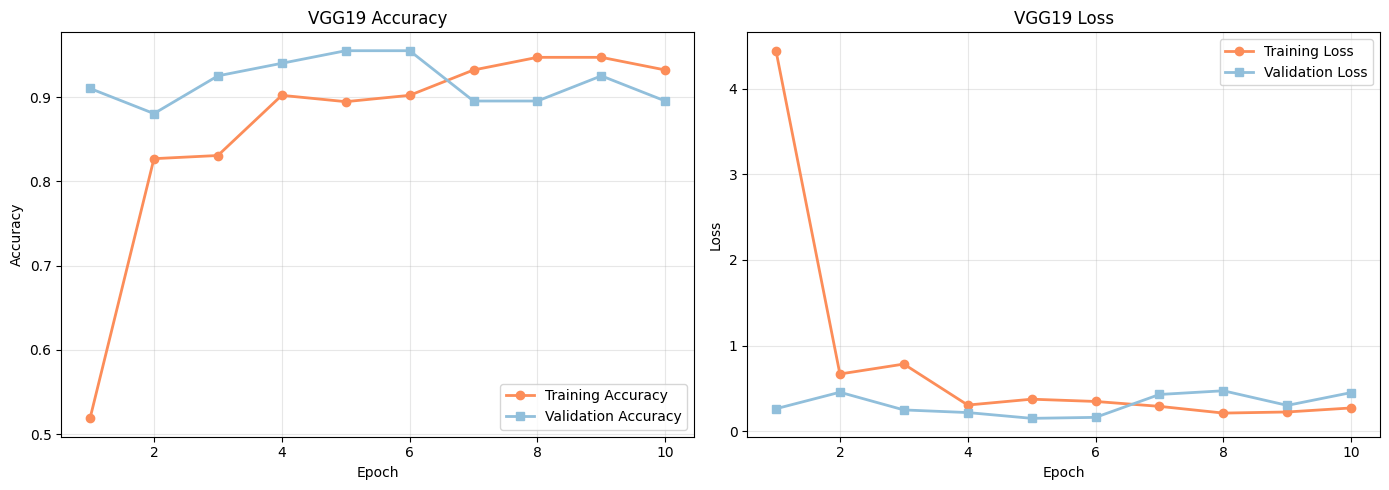

In [47]:
# Plot for VGG19
plot_training_history(VGG19_history, title_prefix='VGG19')

**Thought Challenge**: Compare the performance of our VGG19 model to our previous CNN model. What are some major differences in the training curves?

### Step 3: Evaluate the VGG19 Model on the Test Set

Just like we did for our first CNN model, let's evaluate the VGG19 model on the test set.

#### Evaluate Test Accuracy and Loss
First, let's calculate the test accuracy and loss. Can you recall how to do this?

In [48]:
# Evaluate on the test set
test_loss, test_acc = VGG19_model.evaluate(test_generator_vgg19, verbose=0)
print(f"Test Accuracy: {test_acc:.2%}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 92.86%
Test Loss: 0.2990


Our model correctly classifies the test images about 93% of the time. What an improvement!

#### Visualize Predictions with a Confusion Matrix
Now, let's visualize the predictions of our VGG19 model on the test set with a confusion matrix.

Refer back to Section 1: Step 7 – *Visualize Predictions with a Confusion Matrix* for a refresher on how to do this.

3/3 [==============================] - 1s 251ms/step


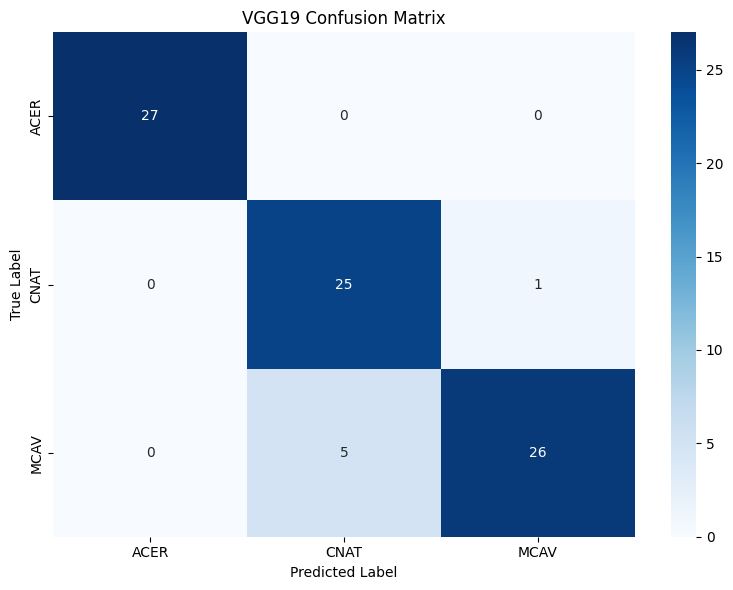

In [49]:
# Generate predictions
vgg19_pred_probs = VGG19_model.predict(test_generator_vgg19)
vgg19_y_pred = np.argmax(vgg19_pred_probs, axis=1)
vgg19_y_true = test_generator_vgg19.classes

# Confusion matrix
cm = confusion_matrix(vgg19_y_true, vgg19_y_pred)
class_names = list(test_generator_vgg19.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("VGG19 Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

Notice how the confusion matrix shows a distinct diagonal pattern, where the true and predicted labels are the same more often than not? This indicates that our model is performing well on all classes. Nice!

#### Detailed Performance with a Classification Report
Finally, let's print out the full classification report.

In [50]:
from sklearn.metrics import classification_report

print("Classification Report (VGG19):")
print(classification_report(vgg19_y_true, vgg19_y_pred, target_names=class_names))

Classification Report (VGG19):
              precision    recall  f1-score   support

        ACER       1.00      1.00      1.00        27
        CNAT       0.83      0.96      0.89        26
        MCAV       0.96      0.84      0.90        31

    accuracy                           0.93        84
   macro avg       0.93      0.93      0.93        84
weighted avg       0.93      0.93      0.93        84



**Thought Challenge**: Compare the performance of our VGG19 model to our previous CNN model. What are some major differences in the classification report? Are there still any problematic classes that the model is struggling with? If so, what do you think is causing this?

### Step 4: Visualize Predictions from the Test Set
First, let's take the raw predictions from our VGG19 model and organize them into a pandas DataFrame with four columns:
 - `Filepath`: Where each image is located
 - `True Label`: The actual species of coral in the image
 - `Predicted Label`: What our model thinks the species is
 - `Confidence`: How confident our model is in its prediction (0-1) 

This organized DataFrame makes it easy to save our model's predictions and create visualizations of the results. 

In [57]:
import os

# Create a mapping from class indices to class names
idx_to_class = {v: k for k, v in test_generator_vgg19.class_indices.items()}

# The filenames already contain the full paths, so we can use them directly
file_paths = test_generator_vgg19.filenames

# Convert class indices to class names
true_class_names = [idx_to_class[idx] for idx in vgg19_y_true]
pred_class_names = [idx_to_class[idx] for idx in vgg19_y_pred]

# Get the confidence scores for the predicted classes
confidence_scores = [vgg19_pred_probs[i][pred_idx] for i, pred_idx in enumerate(vgg19_y_pred)]

# Create the results DataFrame
vgg19_results_df = pd.DataFrame({
    'Filepath': file_paths,
    'True Label': true_class_names,
    'Predicted Label': pred_class_names,
    'Confidence': confidence_scores
})

# Display first few rows
print(vgg19_results_df.head())

                                                                                             Filepath  \
0  /scratch1/09794/kbeavers/tacc-deep-learning-tutorials/data/coral-species/CNAT/colpophyllia_109.jpg   
1      /scratch1/09794/kbeavers/tacc-deep-learning-tutorials/data/coral-species/ACER/acropora_200.jpg   
2   /scratch1/09794/kbeavers/tacc-deep-learning-tutorials/data/coral-species/MCAV/montastraea_092.jpg   
3  /scratch1/09794/kbeavers/tacc-deep-learning-tutorials/data/coral-species/CNAT/colpophyllia_130.jpg   
4   /scratch1/09794/kbeavers/tacc-deep-learning-tutorials/data/coral-species/MCAV/montastraea_037.jpg   

  True Label Predicted Label  Confidence  
0       CNAT            MCAV    0.773621  
1       ACER            ACER    1.000000  
2       MCAV            CNAT    0.825395  
3       CNAT            CNAT    1.000000  
4       MCAV            MCAV    0.999995  


Let's display a few test images along with their predicted labels, true labels, and the model's confidence scores.

This helps visually confirm whether predictions make sense – and helps identify patterns in misclassifications.

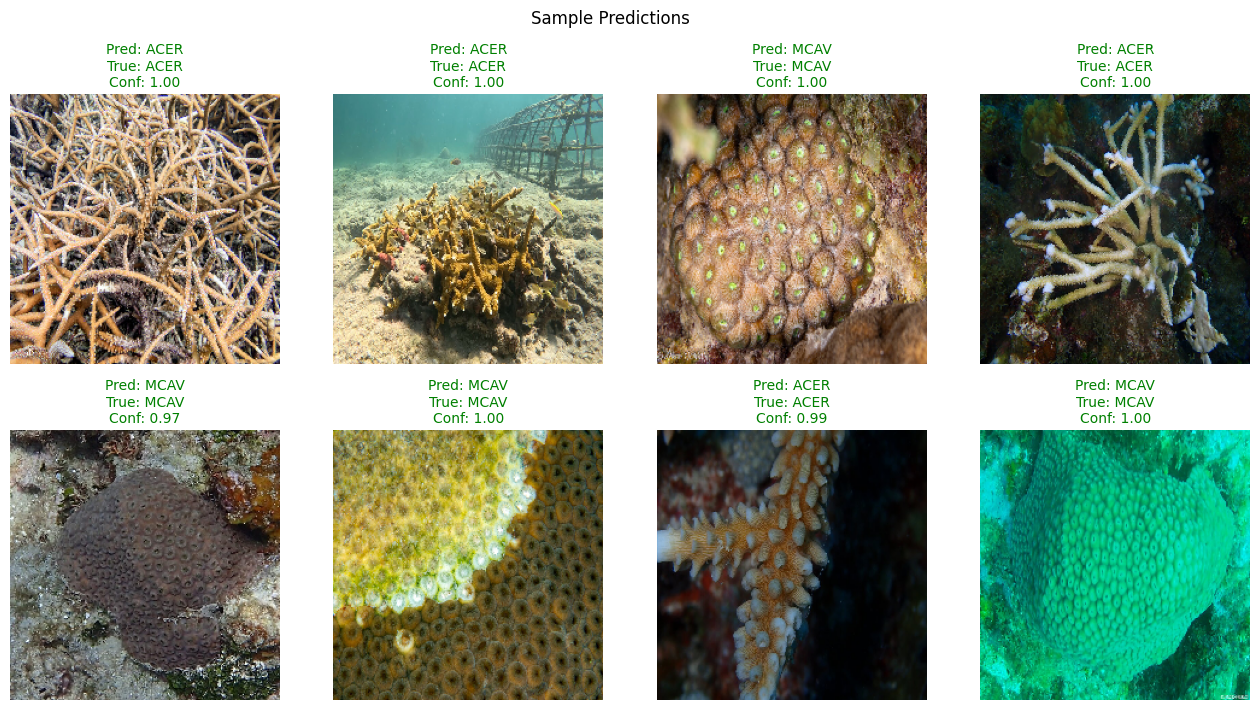

In [59]:
 from tensorflow.keras.preprocessing.image import load_img

# Number of test images to show
num_images = 8

# Sample a few random rows from the test results
sample_df = vgg19_results_df.sample(n=num_images, random_state=123).reset_index(drop=True)

# Set up the plot grid
plt.figure(figsize=(16, 8))
for i in range(num_images):
    row = sample_df.iloc[i]
    img = load_img(row['Filepath'], target_size=(224, 224))

    plt.subplot(2, num_images // 2, i + 1)
    plt.imshow(img)
    plt.axis('off')

    # Determine color based on prediction accuracy
    is_correct = row['Predicted Label'] == row['True Label']
    color = 'green' if is_correct else 'red'

    # Create title with colored text
    title = f"Pred: {row['Predicted Label']}\nTrue: {row['True Label']}\nConf: {row['Confidence']:.2f}"
    plt.title(title, fontsize=10, color=color)

plt.suptitle("Sample Predictions", fontsize=12)
plt.savefig('vgg19_sample_predictions.png', dpi=300)
plt.show()

## Final Thoughts and Wrap-Up

Congratulations! You've now built and evaluated two deep learning models for image classification:

1. **A CNN from scratch**  
   - Gave you hands-on experience building a model layer-by-layer
   - Showed the challenges of training with limited data (e.g. overfitting)

2. **A Transfer Learning model using VGG19**  
   - Leveraged features learned from millions of images (ImageNet)
   - Achieved higher accuracy and better generalization with fewer parameters and less training time

---

### Next Steps

If you're interested in improving this model further, here are some ideas to help push toward **perfect classification accuracy** on this dataset:

- **Fine-tune VGG19**: Unfreeze some of the deeper convolutional layers and retrain the model to better adapt to your specific dataset.
- **Explore Other Architectures**: Experiment with different pre-trained models like ResNet or Inception to compare their performance with VGG19.
- **Enhance Data Augmentation**: Implement more aggressive data augmentation techniques such as color jitter, brightness shifts, cropping, and noise addition to increase model robustness.
- **Improve Image Quality**: Apply image cleaning or filtering techniques to enhance the quality of your dataset.
- **Optimize Model Architecture**: Consider adding Batch Normalization, Dropout, or other regularization techniques to improve model generalization.
---

### Contribute to This Tutorial!

We encourage you to share your improvements and insights with the community. If you develop a model that surpasses our current implementation, we'd love to see it!

Here's how you can contribute:

- **Fork the Repository**: Create your own copy of the repository to work on.
- **Enhance and Document**: Add your new model architecture, results, and any notes or observations.
- S**ubmit a Pull Request**: Share your improvements by submitting a pull request to contribute to this tutorial.

Let's see what you can build!